In [2]:
# Importing required libraries
from sklearn.ensemble import RandomForestClassifier  # Classifier for building the prediction model
from sklearn.metrics import precision_score  # Evaluation metric to measure model performance
import pandas as pd  # Data manipulation library

In [3]:
# Loading data using yfinance and limiting to maximum history available
import yfinance as yf
nvda = yf.Ticker("NVDA")  # Getting stock data for NVDA (NVIDIA)
nvda = nvda.history(period="max")  # Fetching historical data (max period available)

In [4]:
nvda

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1999-01-22 00:00:00-05:00,0.040125,0.044783,0.035587,0.037618,2714688000,0.0,0.0
1999-01-25 00:00:00-05:00,0.040603,0.042036,0.037618,0.041559,510480000,0.0,0.0
1999-01-26 00:00:00-05:00,0.042036,0.042872,0.037737,0.038334,343200000,0.0,0.0
1999-01-27 00:00:00-05:00,0.038453,0.039409,0.036303,0.038215,244368000,0.0,0.0
1999-01-28 00:00:00-05:00,0.038215,0.038453,0.037856,0.038095,227520000,0.0,0.0
...,...,...,...,...,...,...,...
2024-09-16 00:00:00-04:00,116.790001,118.180000,114.360001,116.779999,248772300,0.0,0.0
2024-09-17 00:00:00-04:00,118.169998,118.800003,114.830002,115.589996,231925900,0.0,0.0
2024-09-18 00:00:00-04:00,115.889999,117.699997,113.220001,113.370003,310318900,0.0,0.0


<Axes: xlabel='Date'>

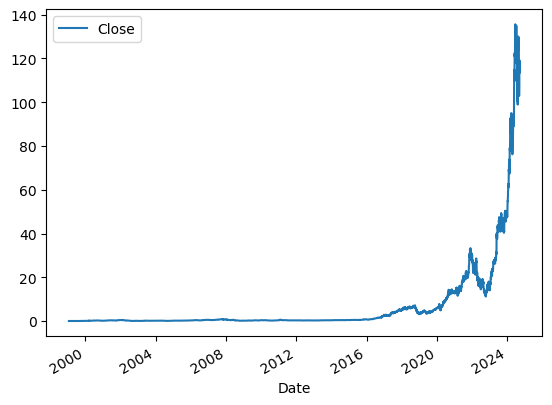

In [5]:
# Plotting the stock price to understand the trend visually
nvda.plot.line(y="Close", use_index=True)

In [7]:
# Adding a "Tomorrow" column which shifts the "Close" price by one day
# This represents the price of the stock for the next day, which we will predict
nvda["Tomorrow"] = nvda["Close"].shift(-1)

In [9]:
nvda

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Tomorrow
Date,,,,,,,,
1999-01-22 00:00:00-05:00,0.040125,0.044783,0.035587,0.037618,2714688000,0.0,0.0,0.041559
1999-01-25 00:00:00-05:00,0.040603,0.042036,0.037618,0.041559,510480000,0.0,0.0,0.038334
1999-01-26 00:00:00-05:00,0.042036,0.042872,0.037737,0.038334,343200000,0.0,0.0,0.038215
1999-01-27 00:00:00-05:00,0.038453,0.039409,0.036303,0.038215,244368000,0.0,0.0,0.038095
1999-01-28 00:00:00-05:00,0.038215,0.038453,0.037856,0.038095,227520000,0.0,0.0,0.036303
...,...,...,...,...,...,...,...,...
2024-09-16 00:00:00-04:00,116.790001,118.180000,114.360001,116.779999,248772300,0.0,0.0,115.589996
2024-09-17 00:00:00-04:00,118.169998,118.800003,114.830002,115.589996,231925900,0.0,0.0,113.370003
2024-09-18 00:00:00-04:00,115.889999,117.699997,113.220001,113.370003,310318900,0.0,0.0,117.870003


In [10]:
# Creating a binary "Target" column
# It will be 1 if the "Tomorrow" price is greater than today's "Close" price (upward movement), 0 otherwise (downward movement)
nvda["Target"] = (nvda["Tomorrow"] > nvda["Close"]).astype(int)

In [11]:
nvda

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Tomorrow,Target
Date,,,,,,,,,
1999-01-22 00:00:00-05:00,0.040125,0.044783,0.035587,0.037618,2714688000,0.0,0.0,0.041559,1
1999-01-25 00:00:00-05:00,0.040603,0.042036,0.037618,0.041559,510480000,0.0,0.0,0.038334,0
1999-01-26 00:00:00-05:00,0.042036,0.042872,0.037737,0.038334,343200000,0.0,0.0,0.038215,0
1999-01-27 00:00:00-05:00,0.038453,0.039409,0.036303,0.038215,244368000,0.0,0.0,0.038095,0
1999-01-28 00:00:00-05:00,0.038215,0.038453,0.037856,0.038095,227520000,0.0,0.0,0.036303,0
...,...,...,...,...,...,...,...,...,...
2024-09-16 00:00:00-04:00,116.790001,118.180000,114.360001,116.779999,248772300,0.0,0.0,115.589996,0
2024-09-17 00:00:00-04:00,118.169998,118.800003,114.830002,115.589996,231925900,0.0,0.0,113.370003,0
2024-09-18 00:00:00-04:00,115.889999,117.699997,113.220001,113.370003,310318900,0.0,0.0,117.870003,1


In [13]:
# Limiting data from the year 2000 onward for simplicity
nvda = nvda.loc["2000-01-01":].copy()

In [14]:
nvda

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Tomorrow,Target
Date,,,,,,,,,
2000-01-03 00:00:00-05:00,0.090282,0.090999,0.084311,0.089446,300912000,0.0,0.0,0.087058,0
2000-01-04 00:00:00-05:00,0.087893,0.088132,0.082639,0.087058,300480000,0.0,0.0,0.084191,0
2000-01-05 00:00:00-05:00,0.084550,0.085983,0.082997,0.084191,188352000,0.0,0.0,0.078698,0
2000-01-06 00:00:00-05:00,0.084191,0.084191,0.075474,0.078698,120480000,0.0,0.0,0.080012,1
2000-01-07 00:00:00-05:00,0.078340,0.080848,0.077146,0.080012,71184000,0.0,0.0,0.082639,1
...,...,...,...,...,...,...,...,...,...
2024-09-16 00:00:00-04:00,116.790001,118.180000,114.360001,116.779999,248772300,0.0,0.0,115.589996,0
2024-09-17 00:00:00-04:00,118.169998,118.800003,114.830002,115.589996,231925900,0.0,0.0,113.370003,0
2024-09-18 00:00:00-04:00,115.889999,117.699997,113.220001,113.370003,310318900,0.0,0.0,117.870003,1


In [15]:
# Defining the RandomForest model with intermediate hyperparameters
# n_estimators (number of trees), min_samples_split (minimum samples required to split an internal node)
model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

In [16]:
# Splitting data into training and testing sets
# Training on the data except for the last 100 rows, testing on the last 100 rows
train = nvda.iloc[:-100]
test = nvda.iloc[-100:]

In [17]:
# Selecting basic predictors (features) for the initial model
predictors = ["Close", "Volume", "Open", "High", "Low"]

In [18]:
# Fitting the model on training data
# Predictors (input features) and Target (output label)
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [19]:
# Making predictions on the test set
predictions = model.predict(test[predictors])

In [20]:
# Converting predictions to a pandas Series for easier manipulation and analysis
predictions = pd.Series(predictions, index=test.index)

In [21]:
# Evaluating the precision score (precision = true positives / (true positives + false positives))
# This helps us understand how accurate our predictions are for the upward movement of stock prices
print(precision_score(test["Target"], predictions))

0.8333333333333334


In [22]:
# Combining the true targets with the predictions for visualization
combined = pd.concat([test["Target"], predictions], axis=1)

<Axes: xlabel='Date'>

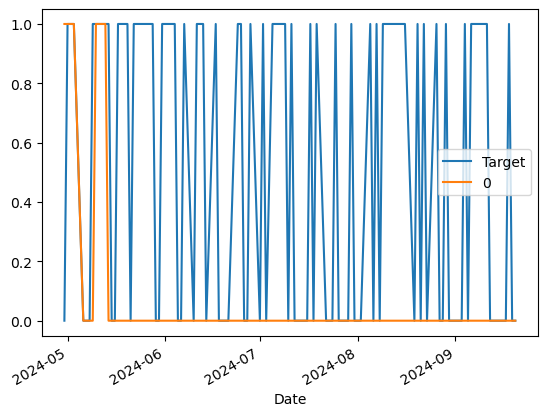

In [23]:
# Plotting the true vs predicted targets to visually assess the performance
combined.plot()

In [24]:
# Defining a function to make predictions and return the combined data with true and predicted values
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    predictions = model.predict(test[predictors])
    predictions = pd.Series(predictions, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], predictions], axis=1)
    return combined

In [25]:
# Backtesting function that iterates through the data and applies the model in chunks (walk-forward validation)
# It helps simulate how the model would have performed historically
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []
    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    return pd.concat(all_predictions)

In [26]:
# Running the backtest on the NVDA data with the defined predictors
predictions = backtest(nvda, model, predictors)

In [27]:
# Checking the distribution of predicted classes (how many 0s and 1s we predicted)
print(predictions["Predictions"].value_counts())

0    2045
1    1674
Name: Predictions, dtype: int64


In [28]:
# Calculating the precision score for the predictions
print(precision_score(predictions["Target"], predictions["Predictions"]))

0.5101553166069295


In [29]:
# Defining horizons for calculating rolling averages and trends
horizons = [2, 5, 60, 250, 1000]  # Short, medium, and long-term trends


In [30]:
new_predictors = []  # A list to store the new predictor names

In [31]:
# Adding rolling average and trend features
for horizon in horizons:
    rolling_averages = nvda.rolling(horizon).mean()  # Calculating rolling averages over different horizons
    
    # Creating a ratio column: Today's Close price divided by the rolling average
    ratio_column = f"Close_Ratio_{horizon}"
    nvda[ratio_column] = nvda["Close"] / rolling_averages["Close"]
    
    # Creating a trend column: Sum of the target (stock price up or down) over the rolling horizon
    trend_column = f"Trend_{horizon}"
    nvda[trend_column] = nvda.shift(1).rolling(horizon).sum()["Target"]
    
    new_predictors += [ratio_column, trend_column]  # Adding the new columns to the list of predictors


In [32]:
# Dropping any rows with missing values after feature engineering
nvda = nvda.dropna()

In [33]:
nvda

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,,,
2003-12-26 00:00:00-05:00,0.167914,0.174793,0.167226,0.173800,363960000,0.0,0.0,0.181137,1,1.021104,1.0,1.046287,4.0,1.177283,34.0,1.291600,134.0,0.809514,483.0
2003-12-29 00:00:00-05:00,0.177086,0.181749,0.176246,0.181137,756624000,0.0,0.0,0.181519,1,1.020672,2.0,1.064690,4.0,1.219251,34.0,1.342408,135.0,0.843319,484.0
2003-12-30 00:00:00-05:00,0.179226,0.184959,0.179073,0.181519,550884000,0.0,0.0,0.177315,0,1.001055,2.0,1.042125,4.0,1.214567,34.0,1.341765,135.0,0.844717,485.0
2003-12-31 00:00:00-05:00,0.181442,0.182283,0.174411,0.177315,497268000,0.0,0.0,0.176398,0,0.988284,1.0,1.007030,3.0,1.179849,34.0,1.307470,135.0,0.824774,485.0
2004-01-02 00:00:00-05:00,0.180144,0.182589,0.176398,0.176398,436416000,0.0,0.0,0.182130,1,0.997407,0.0,0.990812,3.0,1.167532,33.0,1.297849,134.0,0.820140,484.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-13 00:00:00-04:00,119.080002,119.959999,117.599998,119.099998,238358300,0.0,0.0,116.779999,0,0.999832,1.0,1.045302,4.0,1.002579,29.0,1.460605,144.0,3.247307,539.0
2024-09-16 00:00:00-04:00,116.790001,118.180000,114.360001,116.779999,248772300,0.0,0.0,115.589996,0,0.990164,0.0,1.006705,3.0,0.984982,29.0,1.427055,143.0,3.174989,539.0
2024-09-17 00:00:00-04:00,118.169998,118.800003,114.830002,115.589996,231925900,0.0,0.0,113.370003,0,0.994879,0.0,0.983728,2.0,0.976451,29.0,1.407554,143.0,3.133836,538.0


In [34]:
# Updating the RandomForest model with more trees and a smaller min_samples_split for better performance
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)


In [35]:
# Updating the predict function to use probabilistic prediction (predict_proba) and a threshold for classification
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    predictions = model.predict_proba(test[predictors])[:, 1]  # Predicting probabilities for the positive class (Target = 1)
    predictions[predictions >= .6] = 1  # Setting threshold for positive class (0.6 instead of 0.5 for better precision)
    predictions[predictions < .6] = 0  # Anything below 0.6 is classified as 0
    predictions = pd.Series(predictions, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], predictions], axis=1)
    return combined

In [36]:
# Running the backtest again with the new predictors (including rolling averages and trends)
predictions = backtest(nvda, model, new_predictors)

In [37]:
# Checking the distribution of predictions again
print(predictions["Predictions"].value_counts())

0.0    2399
1.0     319
Name: Predictions, dtype: int64


In [38]:
# Evaluating the precision score with the new predictors
print(precision_score(predictions["Target"], predictions["Predictions"]))

0.5830721003134797
